## Install required libraries

In [ ]:
!pip install matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

## Import required libraries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## Change settings

In [3]:
# Warning display off
import warnings
warnings.simplefilter('ignore')

# Change default font size
plt.rcParams['font.size'] = 14

# Change default graph size
plt.rcParams['figure.figsize'] = (6,6)

# Square indicate ON
plt.rcParams['axes.grid'] = True

# Set precision of floating-point numbers in numpy
np.set_printoptions(suppress=True, precision=5)

## GPU utilization

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Define the common function

### Function for loss calculation

In [5]:
def eval_loss(loader, device, net, criterion):

    # Retrieve the first set from the data loader
    for images, labels in loader:
        break

    # Send to GPU
    inputs = images.to(device)
    labels = labels.to(device)

    # Prediction calculation
    outputs = net(inputs)

    # Loss calculation
    loss = criterion(outputs, labels)

    return loss

### Function for fit

In [6]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    # To show a progress bar, we import tqdm
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        # Number of correct answers per epoch (for accuracy calculation)
        n_train_acc, n_val_acc = 0, 0

        # Cumulative loss per epoch (before averaging)
        train_loss, val_loss = 0, 0

        # Number of cumulative data records per epoch
        n_train, n_test = 0, 0

        # Training phase
        net.train()

        for inputs, labels in tqdm(train_loader):
            # Number of data records per batch
            train_batch_size = len(labels)

            # Number of data records accumulated per epoch
            n_train += train_batch_size

            # Transfer to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Initialize gradient
            optimizer.zero_grad()

            # 1. Calculate prediction
            outputs = net(inputs)

            # 2. Calculate loss
            loss = criterion(outputs, labels)

            # 3. Calculate gradient
            loss.backward()

            # 4. Adjust parameters
            optimizer.step()

            # Calculate the prediction label
            predicted = torch.max(outputs, 1)[1]

            # Calculate loss
            # Since the loss is calculated as an average, revert it to
            # the pre-averaging loss and add it back
            train_loss += loss.item() * train_batch_size

            # Calculate accuracy
            n_train_acc += (predicted == labels).sum().item()

        # Prediction phase
        net.eval()

        for inputs_test, labels_test in test_loader:
            # Number of data records per batch
            test_batch_size = len(labels_test)

            # Number of data records accumulated per epoch
            n_test += test_batch_size

            # Transfer to GPU
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 1. Calculate prediction
            outputs_test = net(inputs_test)

            # 2. Calculate loss
            loss_test = criterion(outputs_test, labels_test)

            # Calculate the prediction label
            predicted_test = torch.max(outputs_test, 1)[1]

            # Calculate loss
            # Since the loss is calculated as an average, revert it to
            # the pre-averaging loss and add it back
            val_loss +=  loss_test.item() * test_batch_size

            # Calculate accuracy
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # Calculate the accuracy of the training and the validation
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test

        # Calculate the loss of the training and the validation
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

### Function for learning log analysis

In [7]:
def evaluate_history(history):
    # Confirm the loss values and accuracies
    print(f'Initial: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}')
    print(f'Final: Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # Display the learning curve for the loss
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('Repetition counts')
    plt.ylabel('Loss')
    plt.title('Learning curve of the Loss')
    plt.legend()
    plt.show()

    # Display learning curve for the accuracy
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('Repetition counts')
    plt.ylabel('Accuracy')
    plt.title('Learning curve of the Accuracy')
    plt.legend()
    plt.show()

### Function for random number locking

In [8]:
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## Prepare for the dataset

In [11]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [ ]:
data_root = './data'

# Training dataset
train_set1 = datasets.CIFAR10(
    root =  data_root, train = True,
    download = True, transform = transform1)

# Validation dataset
test_set1 = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform1)

In [13]:
image1, label1 = train_set1[0]

# Minibatch size specification
batch_size = 100

# Training Data Loader (Since it's for training, shuffle the data)
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# Data Loader for Validation (Shuffling is not required during validation)
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False)

# Retrieve the first set from train_loader1
for images1, labels1 in train_loader1:
    break

# Define correct answer label
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Define the class of the prediction model

In [14]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    # nn.Conv2d
    # 1st argument: Number of input channels
    # 2nd argument: Number of output channels
    # 3rd argument: Kernel size
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    # 6272 explanation
    # Each time the Conv2d function is processed, the number of output data pixels decreases by the kernel size minus one.
    # Processing with the MaxPool2d function halves the image size.
    # Image size: 32 x 32 -> 30 x 30 -> 28 x 28 - > 14 x 14
    # 6272 = 32 channnels x 14 image size x 14 image size
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

## Prepare for the calculation

In [15]:
# Dimension of input
n_input = image1.shape[0]

# Dimension of output
n_output = len(classes)

# Number of hidden layer nodes
n_hidden = 128

In [16]:
# Learning rate
lr = 0.01

# Random number fixing
torch_seed()

# Create predict function
net = CNN(n_output, n_hidden).to(device)

# Create loss function
criterion = nn.CrossEntropyLoss()

# Create Optimization function
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Repetition counts
num_epochs = 50

# Record evaluation results
history = np.zeros((0,5))

## Execute image recognition

In [ ]:
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

## Confirm the loss values and accuracies and display the learning curve

Initial: Loss: 1.86593 Accuracy: 0.34660
Final: Loss: 1.88229 Accuracy: 0.66350


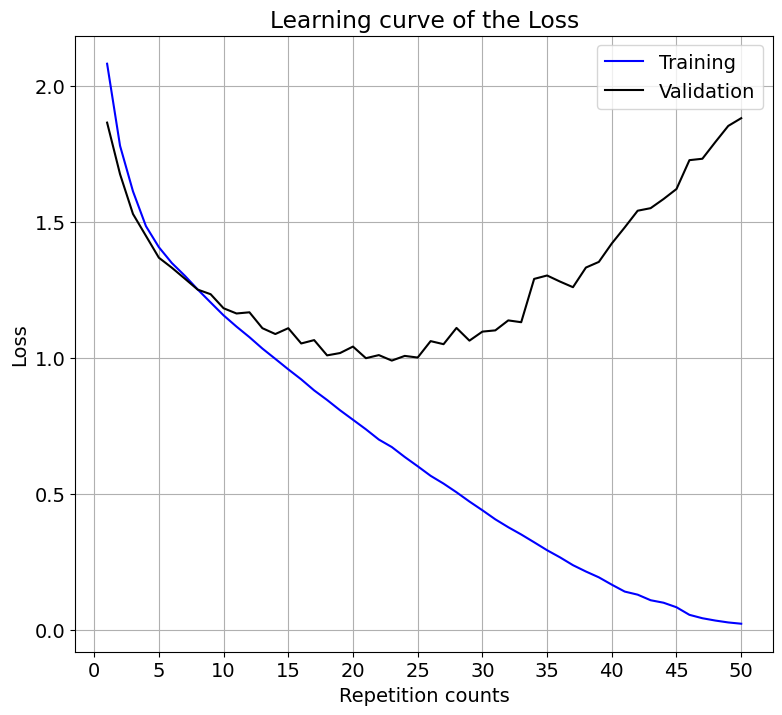

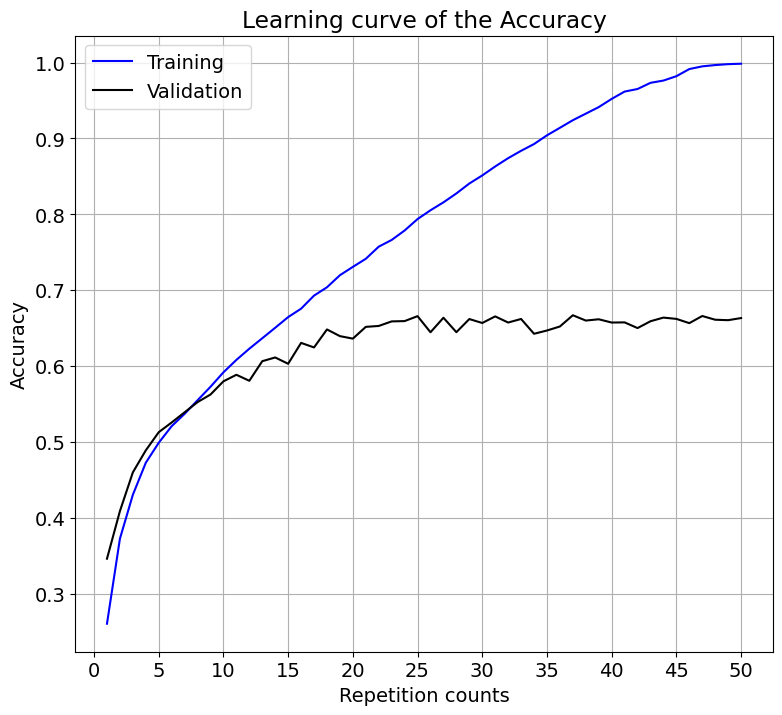

In [18]:
evaluate_history(history)

- From the loss of the learning curve, this calculation causes overfitting. We should have stopped at 20 repetitions.  
- Unfortunately, the accuracy is low (about 66%). So, we'll be able to perform tuning for this model in the next chapter.